# San Francisco Rental Prices Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [9]:
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv

In [10]:
# Read the Mapbox API key
load_dotenv()
mapbox_token = os.getenv("MAPBOX_API_KEY")

# Import Data

In [11]:
# Import the CSVs to Pandas DataFrames
file_path = Path("Data/sfo_neighborhoods_census_data.csv")
sfo_data = pd.read_csv(file_path, index_col="year")

file_path = Path("Data/neighborhoods_coordinates.csv")
df_neighborhood_locations = pd.read_csv(file_path)

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

In [12]:
# Define Panel Visualization Functions
def housing_units_per_year():
    """Housing Units Per Year."""
    housing_units = sfo_data['housing_units']
    housing_units = housing_units.groupby([sfo_data.index]).mean()
    
    housing_units_fig = plt.figure()
    housing_units_plot = housing_units.plot.bar(x='year', ylim=[370000, 385000], title='Average Number of Housing Units Per Year')
    plt.close(housing_units_fig)
    
    return pn.pane.Matplotlib(housing_units_fig)

def average_gross_rent():
    """Average Gross Rent in San Francisco Per Year."""
    
    average_rent_sqr_foot = sfo_data[["sale_price_sqr_foot", "gross_rent"]].groupby(sfo_data.index).mean()
    
    gross_rent_fig = plt.figure()
    average_rent_plot = average_rent_sqr_foot["gross_rent"].plot()
    average_rent_plot.set_xlabel("Year")
    average_rent_plot.set_ylabel("Gross Rent")
    average_rent_plot.set_title("Average Gross Rent in San Francisco")
    plt.close(gross_rent_fig)
    
    return pn.pane.Matplotlib(gross_rent_fig)

def average_sales_price():
    """Average Sales Price Per Year."""
    
    price_fig = plt.figure()
    average_price_plot = sfo_data[["sale_price_sqr_foot"]].plot()
    average_price_plot.set_xlabel("Year")
    average_price_plot.set_ylabel("Average Sales Price")
    average_price_plot.set_title("Average Sales Price in San Francisco")
    plt.close(price_fig)
    
    return pn.pane.Matplotlib(price_fig)

def average_price_by_neighborhood():
    sfo_data_new = sfo_data.groupby([sfo_data.index, "neighborhood"]).mean()
    sfo_data_new.reset_index(inplace=True)
    #sfo_sales_df = pd.DataFrame(sfo_sales).reset_index()
    sfo_sales_df = sfo_data_new.hvplot.line(
        x="year",
        y="sale_price_sqr_foot",
        colormap="coolwarm",
        title="SF Sale per Square foot per Year",
        groupby = "neighborhood"
    )
    return sfo_sales_df

def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods."""
    avg_value_per_neighborhood = sfo_data.groupby("neighborhood").mean()
    avg_value_per_neighborhood = avg_value_per_neighborhood.reset_index()
    top_10_most_expensive = avg_value_per_neighborhood.nlargest(10, 'sale_price_sqr_foot').reset_index()
    top10_plot = px.bar(top_10_most_expensive,
    x="neighborhood",
    y="sale_price_sqr_foot",
    title="Top 10 Most Expensive Neighborhoods in San Francisco",
    )
    return top10_plot

def parallel_coordinates():
    """Parallel Coordinates Plot."""
    avg_value_per_neighborhood = sfo_data.groupby("neighborhood").mean()
    top_10_most_expensive = avg_value_per_neighborhood.nlargest(10, 'sale_price_sqr_foot').reset_index()
    top_10_parallel = px.parallel_coordinates(
    top_10_most_expensive,
    color='sale_price_sqr_foot')
    return top_10_parallel

def parallel_categories():
    """Parallel Categories Plot."""
    avg_value_per_neighborhood = sfo_data.groupby("neighborhood").mean()
    top_10_ex_neighborhood = avg_value_per_neighborhood.nlargest(10, 'sale_price_sqr_foot').reset_index()
    top_10_parallel_categories = px.parallel_categories(
    top_10_ex_neighborhood,
    dimensions=["neighborhood", "sale_price_sqr_foot", "housing_units", "gross_rent"],
    color="sale_price_sqr_foot",
    color_continuous_scale=px.colors.sequential.Inferno,
    )
    return top_10_parallel_categories

def neighborhood_map():
    """Neighborhood Map"""
    px.set_mapbox_access_token(mapbox_token)
    file_path = Path("Data/neighborhoods_coordinates.csv")
    df_neighborhood_location = pd.read_csv(file_path)
    avg_value_per_neighborhood = sfo_data.groupby([sfo_data["neighborhood"]]).mean()
    avg_value_per_neighborhood = avg_value_per_neighborhood.reset_index()
    avg_value_location = pd.concat([avg_value_per_neighborhood, df_neighborhood_location], axis="columns", join="inner")
    location_map = px.scatter_mapbox(
    avg_value_location,
    lat="Lat",
    lon="Lon",
    size="sale_price_sqr_foot",
    color="gross_rent",
    color_continuous_scale=px.colors.cyclical.IceFire,
    #title="Average Sale Price per Square Foot and Gross Rent in San Francisco",
    zoom=11,
    width=800,
)
    return location_map

## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

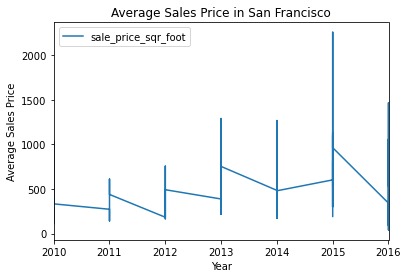

In [13]:
welcome_tab = pn.pane.Markdown(width = 900,)
neighborhood_analysis_tab = pn.pane.Markdown()
SF_dashboard = pn.Tabs(
    ("Welcome", pn.Column(neighborhood_analysis_tab, neighborhood_map())),
    ("Yearly Market Analysis", pn.Row(housing_units_per_year(), average_gross_rent(), average_sales_price())),
    ("Neighborhood Analysis", pn.Column(average_price_by_neighborhood(), top_most_expensive_neighborhoods())),
    ("Interactive Market Analysis by Neighborhood",pn.Column(parallel_coordinates(), parallel_categories(), width = 960),))
main_dashboard = pn.Column(pn.Row(welcome_tab), SF_dashboard, width = 900)

## Serve the Panel Dashboard

Column(width=900)
    [0] Row
        [0] Markdown(None, width=900)
    [1] Tabs
        [0] Column
            [0] Markdown(None)
            [1] Plotly(Figure)
        [1] Row
            [0] Matplotlib(Figure)
            [1] Matplotlib(Figure)
            [2] Matplotlib(Figure)
        [2] Column
            [0] Row
                [0] HoloViews(DynamicMap)
                [1] Column
                    [0] WidgetBox
                        [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                    [1] VSpacer()
            [1] Plotly(Figure)
        [3] Column(width=960)
            [0] Plotly(Figure)
            [1] Plotly(Figure)
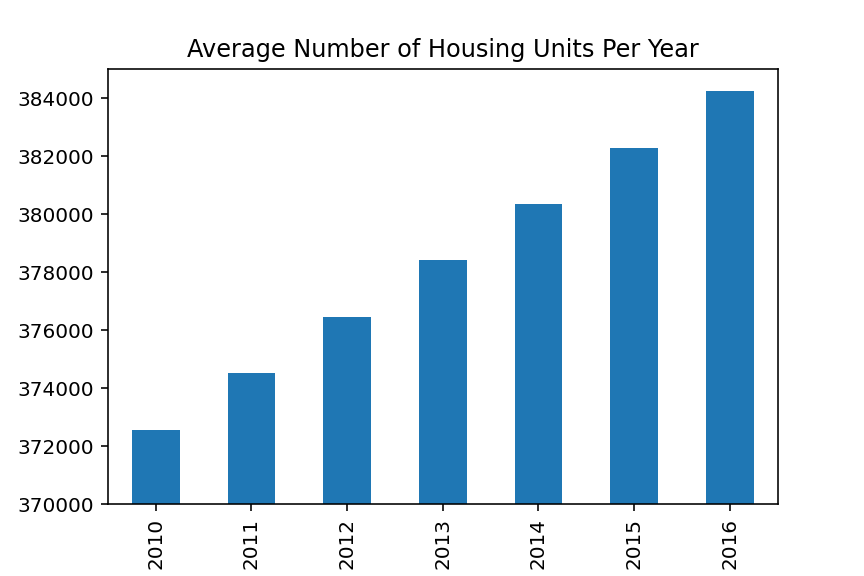
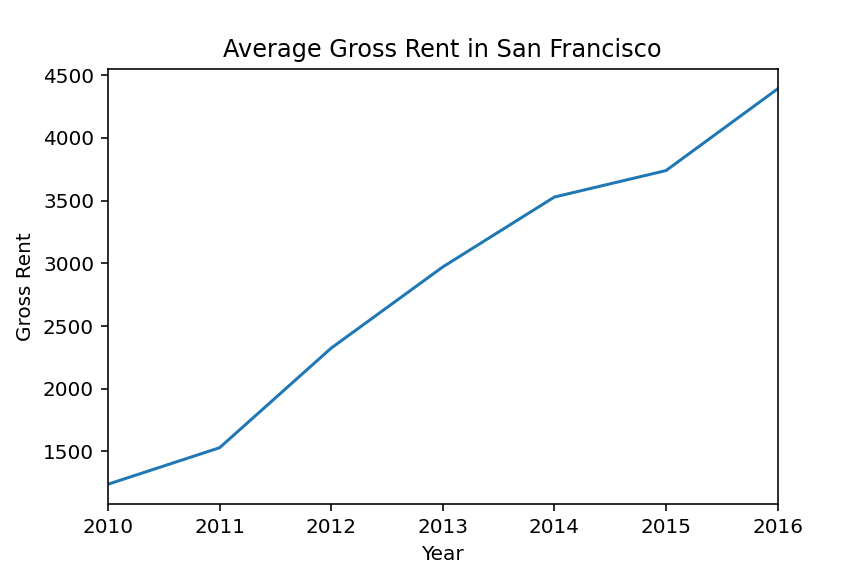
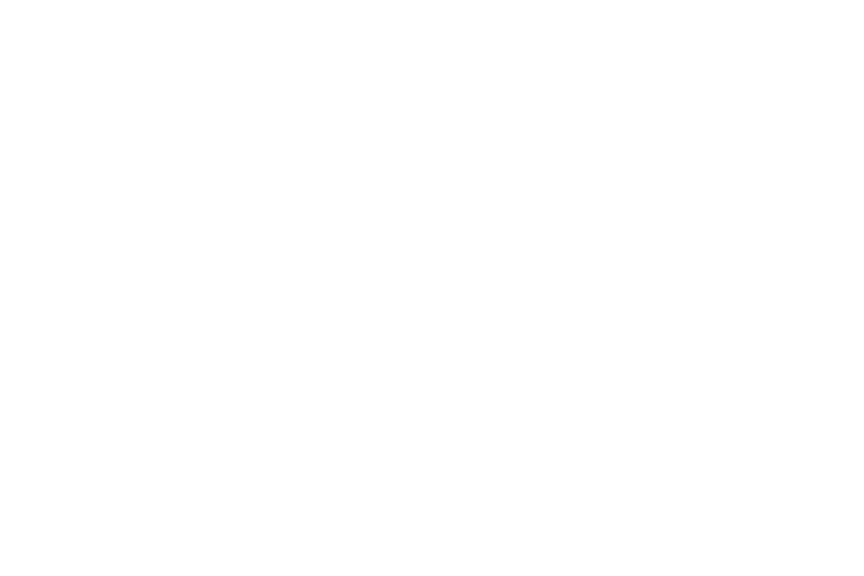

In [8]:
main_dashboard.servable()